In [ ]:

# Analysis Plan:
# 1. Load rule_hybrid_2.0_designs.csv (allosteric candidates)
#    - All motifs are 9-mers, so rank directly by raw MJ score
#    - Select top 50 unique full-length sequences
# 2. Load hybrid_competitive_designs.csv (competitive candidates)
#    - Motifs have varying lengths (mix of 17-mer single/double mutants)
#    - Fit quadratic regression: Raw MJ Score ~ Motif Length
#    - Calculate Residual Score = Actual - Predicted
#    - Rank by Residual Score, select top 50 unique sequences
# 3. Combine into 100-candidate portfolio
# 4. Calculate developability metrics: pI and GRAVY score
# 5. Export final_synthesis_portfolio_v2.csv

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import warnings
warnings.filterwarnings('ignore')

print("Loading datasets...")


Loading datasets...


In [ ]:

# Load allosteric candidates (Rule-Hybrid 2.0)
allosteric_df = pd.read_csv('rule_hybrid_2.0_designs.csv')

print(f"Loaded {len(allosteric_df)} allosteric designs")
print(f"Columns: {list(allosteric_df.columns)}")
print("\nFirst few rows:")
print(allosteric_df.head())


Loaded 2835 allosteric designs
Columns: ['Scaffold', 'Parent_Motif', 'Motif', 'Mutations', 'Design_Sequence', 'MJ_Score_Raw']

First few rows:
  Scaffold Parent_Motif      Motif Mutations  \
0     2QMT    VQCLVCVVI  VQCLVCIII   V7I,V8I   
1     1FNA    VQCLVCVVI  VQCLVCIII   V7I,V8I   
2     1TEN    VQCLVCVVI  VQCLVCIII   V7I,V8I   
3     2QMT    VQCVLCVVI  VQCVLCIII   V7I,V8I   
4     1TEN    VQCVLCVVI  VQCVLCIII   V7I,V8I   

                                     Design_Sequence  MJ_Score_Raw  
0  MIEKKIEKLEEHLGLVQCLVCIIIAESVEQVLSLKDAADLAVVQKT...       -3067.7  
1  MQYKLILNGKTLKGETTTEAVQCLVCIIIVDAATAEKVFKQYANDN...       -3067.7  
2       GSDTITNATIVQCLVCIIIKVQAPDYNVTAKAIGSLRAQACKVV       -3067.7  
3  MIEKKIEKLEEHLGLVQCVLCIIIAESVEQVLSLKDAADLAVVQKT...       -3067.7  
4       GSDTITNATIVQCVLCIIIKVQAPDYNVTAKAIGSLRAQACKVV       -3067.7  


In [ ]:

# Verify all allosteric motifs are 9-mers
allosteric_df['Motif_Length'] = allosteric_df['Motif'].str.len()
print(f"Motif length distribution:")
print(allosteric_df['Motif_Length'].value_counts())

# Confirm all are 9-mers as expected
assert allosteric_df['Motif_Length'].nunique() == 1, "Expected all motifs to be 9-mers"
assert allosteric_df['Motif_Length'].iloc[0] == 9, "Expected motif length of 9"
print("\n✓ Confirmed: All allosteric motifs are 9-mers")


Motif length distribution:
Motif_Length
9    2835
Name: count, dtype: int64

✓ Confirmed: All allosteric motifs are 9-mers


In [ ]:

# Select top 50 allosteric candidates by raw MJ score (most negative is best)
# Already sorted by MJ score in the file (most negative first)
print(f"MJ Score range: {allosteric_df['MJ_Score_Raw'].min()} to {allosteric_df['MJ_Score_Raw'].max()}")

# Sort by MJ_Score_Raw (most negative first)
allosteric_df_sorted = allosteric_df.sort_values('MJ_Score_Raw', ascending=True).reset_index(drop=True)

# Select top 50 unique full-length sequences
top_50_allosteric = allosteric_df_sorted.drop_duplicates(subset='Design_Sequence').head(50).copy()

print(f"\n✓ Selected top 50 unique allosteric sequences")
print(f"Score range: {top_50_allosteric['MJ_Score_Raw'].min()} to {top_50_allosteric['MJ_Score_Raw'].max()}")
print(f"Number of unique motifs: {top_50_allosteric['Motif'].nunique()}")
print(f"Scaffold distribution:\n{top_50_allosteric['Scaffold'].value_counts()}")


MJ Score range: -3067.7000000000103 to -2241.839999999997

✓ Selected top 50 unique allosteric sequences
Score range: -3067.7000000000103 to -3067.7000000000035
Number of unique motifs: 18
Scaffold distribution:
Scaffold
2QMT    18
1TEN    16
1FNA    16
Name: count, dtype: int64


In [ ]:

# Load competitive candidates (Hybrid Competitive)
competitive_df = pd.read_csv('hybrid_competitive_designs.csv')

print(f"Loaded {len(competitive_df)} competitive designs")
print(f"Columns: {list(competitive_df.columns)}")
print("\nFirst few rows:")
print(competitive_df.head())


Loaded 16820 competitive designs
Columns: ['motif', 'parent_motif', 'mutation_type', 'mutations', 'scaffold', 'loop_position', 'design_sequence', 'raw_mj_score']

First few rows:
               motif       parent_motif mutation_type mutations scaffold  \
0  ARDFQYYFSGSFPTPHH  ARDYQYYFSGSYPTPHH        double  Y4F,Y12F     1FNA   
1  ARDFQYYFSGSFPTPHH  ARDYQYYFSGSYPTPHH        double  Y4F,Y12F     1FNA   
2  ARDFQYYFSGSFPTPHH  ARDYQYYFSGSYPTPHH        double  Y4F,Y12F     1TEN   
3  ARDFQYYFSGSFPTPHH  ARDYQYYFSGSYPTPHH        double  Y4F,Y12F     1TEN   
4  ARDYQYFFSGSFPTPHH  ARDYQYYFSGSYPTPHH        double  Y7F,Y12F     1FNA   

  loop_position                                    design_sequence  \
0         65-68  AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...   
1         40-43  AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGARDFQY...   
2         55-58  GKVINGEQCKVTCSYQPQCDYAQDEGKATFTGCVDAGKKGDPLVKA...   
3         30-33  GKVINGEQCKVTCSYQPQCDYAQDEGKATFARDFQYYFSGSFPTPH...   
4         40-4

In [ ]:

# Verify competitive motif lengths
competitive_df['Motif_Length'] = competitive_df['motif'].str.len()
print(f"Motif length distribution:")
print(competitive_df['Motif_Length'].value_counts().sort_index())

print(f"\nMutation type distribution:")
print(competitive_df['mutation_type'].value_counts())

# Check score range
print(f"\nRaw MJ Score range: {competitive_df['raw_mj_score'].min()} to {competitive_df['raw_mj_score'].max()}")


Motif length distribution:
Motif_Length
17    16820
Name: count, dtype: int64

Mutation type distribution:
mutation_type
double    15764
single     1056
Name: count, dtype: int64

Raw MJ Score range: -71.12999999999988 to -52.819999999999965


In [ ]:

# All competitive motifs are 17-mers (single and double mutants)
# However, per finding f22, we need to implement length-independent scoring
# using a quadratic regression model: Raw MJ Score ~ Motif Length

# Since all competitive motifs are the same length (17), the regression will be trivial
# Let's check if there's actually length variation we need to account for
print("IMPORTANT NOTE:")
print("All competitive motifs are 17-mers, so length correction is technically not needed.")
print("However, per the research objective, we will implement the Residual Score method")
print("as specified in finding f22 for consistency with the documented methodology.")
print("\nSince all lengths are identical, the residual scores will equal (Raw Score - Mean Score).")


IMPORTANT NOTE:
All competitive motifs are 17-mers, so length correction is technically not needed.
However, per the research objective, we will implement the Residual Score method
as specified in finding f22 for consistency with the documented methodology.

Since all lengths are identical, the residual scores will equal (Raw Score - Mean Score).


In [ ]:

# Implement quadratic regression for Residual Score calculation
# Even though all motifs are length 17, we'll follow the documented methodology

# Prepare data for regression
X = competitive_df['Motif_Length'].values.reshape(-1, 1)
y = competitive_df['raw_mj_score'].values

# Create polynomial features (degree=2 for quadratic)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

# Fit the model
model = LinearRegression()
model.fit(X_poly, y)

# Get predicted scores
y_pred = model.predict(X_poly)

# Calculate Residual Score = Actual - Predicted
competitive_df['Residual_Score'] = competitive_df['raw_mj_score'] - y_pred

print("Quadratic regression model fitted:")
print(f"Coefficients: intercept={model.intercept_:.4f}, coeffs={model.coef_}")
print(f"\nSince all motifs have the same length (17), the predicted score is constant:")
print(f"Mean predicted score: {y_pred.mean():.4f}")
print(f"Std of predicted scores: {y_pred.std():.6f}")
print(f"\nResidual Score statistics:")
print(f"Mean: {competitive_df['Residual_Score'].mean():.10f}")
print(f"Min: {competitive_df['Residual_Score'].min():.4f}")
print(f"Max: {competitive_df['Residual_Score'].max():.4f}")
print(f"Std: {competitive_df['Residual_Score'].std():.4f}")


Quadratic regression model fitted:
Coefficients: intercept=-62.7099, coeffs=[0. 0. 0.]

Since all motifs have the same length (17), the predicted score is constant:
Mean predicted score: -62.7099
Std of predicted scores: 0.000000

Residual Score statistics:
Mean: -0.0000000000
Min: -8.4201
Max: 9.8899
Std: 2.8189


In [ ]:

# Rank competitive designs by Residual Score (most negative is best)
competitive_df_sorted = competitive_df.sort_values('Residual_Score', ascending=True).reset_index(drop=True)

# Select top 50 unique full-length sequences
top_50_competitive = competitive_df_sorted.drop_duplicates(subset='design_sequence').head(50).copy()

print(f"✓ Selected top 50 unique competitive sequences")
print(f"Residual Score range: {top_50_competitive['Residual_Score'].min():.4f} to {top_50_competitive['Residual_Score'].max():.4f}")
print(f"Raw MJ Score range: {top_50_competitive['raw_mj_score'].min():.4f} to {top_50_competitive['raw_mj_score'].max():.4f}")
print(f"Number of unique motifs: {top_50_competitive['motif'].nunique()}")
print(f"Scaffold distribution:\n{top_50_competitive['scaffold'].value_counts()}")
print(f"Mutation type distribution:\n{top_50_competitive['mutation_type'].value_counts()}")


✓ Selected top 50 unique competitive sequences
Residual Score range: -8.4201 to -7.8301
Raw MJ Score range: -71.1300 to -70.5400
Number of unique motifs: 14
Scaffold distribution:
scaffold
1TEN    26
1FNA    24
Name: count, dtype: int64
Mutation type distribution:
mutation_type
double    50
Name: count, dtype: int64


In [ ]:

# Prepare allosteric candidates for final portfolio
allosteric_final = pd.DataFrame({
    'Epitope_Target': 'Allosteric',
    'Sequence': top_50_allosteric['Design_Sequence'],
    'Motif': top_50_allosteric['Motif'],
    'Scaffold': top_50_allosteric['Scaffold'],
    'Original_Rank_in_Strategy': range(1, 51),
    'Binding_Score': top_50_allosteric['MJ_Score_Raw']
})

# Prepare competitive candidates for final portfolio
competitive_final = pd.DataFrame({
    'Epitope_Target': 'Competitive',
    'Sequence': top_50_competitive['design_sequence'],
    'Motif': top_50_competitive['motif'],
    'Scaffold': top_50_competitive['scaffold'],
    'Original_Rank_in_Strategy': range(1, 51),
    'Binding_Score': top_50_competitive['Residual_Score']
})

print(f"Allosteric candidates prepared: {len(allosteric_final)}")
print(f"Competitive candidates prepared: {len(competitive_final)}")


Allosteric candidates prepared: 50
Competitive candidates prepared: 50


In [ ]:

# Combine allosteric and competitive candidates
portfolio_df = pd.concat([allosteric_final, competitive_final], ignore_index=True)

# Add Final_Rank column (1-100)
portfolio_df['Final_Rank'] = range(1, 101)

print(f"✓ Combined portfolio: {len(portfolio_df)} candidates")
print(f"\nEpitope target distribution:")
print(portfolio_df['Epitope_Target'].value_counts())
print(f"\nScaffold distribution:")
print(portfolio_df['Scaffold'].value_counts())


✓ Combined portfolio: 100 candidates

Epitope target distribution:
Epitope_Target
Allosteric     50
Competitive    50
Name: count, dtype: int64

Scaffold distribution:
Scaffold
1TEN    42
1FNA    40
2QMT    18
Name: count, dtype: int64


In [ ]:

# Calculate developability metrics: pI (Isoelectric Point) and GRAVY score
# Using BioPython's ProteinAnalysis

def calculate_pi_and_gravy(sequence):
    """Calculate pI and GRAVY score for a protein sequence"""
    try:
        analyzer = ProteinAnalysis(sequence)
        pi = analyzer.isoelectric_point()
        gravy = analyzer.gravy()
        return pi, gravy
    except Exception as e:
        print(f"Error analyzing sequence: {e}")
        return None, None

print("Calculating pI and GRAVY scores for all 100 candidates...")
pi_values = []
gravy_values = []

for seq in portfolio_df['Sequence']:
    pi, gravy = calculate_pi_and_gravy(seq)
    pi_values.append(pi)
    gravy_values.append(gravy)

portfolio_df['pI'] = pi_values
portfolio_df['GRAVY_Score'] = gravy_values

print("✓ Developability metrics calculated")
print(f"\npI range: {portfolio_df['pI'].min():.2f} to {portfolio_df['pI'].max():.2f}")
print(f"GRAVY score range: {portfolio_df['GRAVY_Score'].min():.3f} to {portfolio_df['GRAVY_Score'].max():.3f}")


Calculating pI and GRAVY scores for all 100 candidates...
✓ Developability metrics calculated

pI range: 4.55 to 8.85
GRAVY score range: -0.913 to 0.666


In [ ]:

# Reorder columns to match required format and save final portfolio
final_portfolio = portfolio_df[[
    'Final_Rank', 
    'Epitope_Target', 
    'Sequence', 
    'Motif', 
    'Scaffold', 
    'Original_Rank_in_Strategy', 
    'Binding_Score', 
    'pI', 
    'GRAVY_Score'
]]

# Save to CSV
output_file = 'final_synthesis_portfolio_v2.csv'
final_portfolio.to_csv(output_file, index=False)

print(f"✓ Final synthesis portfolio saved to: {output_file}")
print(f"\nFinal portfolio summary:")
print(f"Total candidates: {len(final_portfolio)}")
print(f"Allosteric: {(final_portfolio['Epitope_Target'] == 'Allosteric').sum()}")
print(f"Competitive: {(final_portfolio['Epitope_Target'] == 'Competitive').sum()}")
print("\nFirst 5 rows:")
print(final_portfolio.head())


✓ Final synthesis portfolio saved to: final_synthesis_portfolio_v2.csv

Final portfolio summary:
Total candidates: 100
Allosteric: 50
Competitive: 50

First 5 rows:
   Final_Rank Epitope_Target  \
0           1     Allosteric   
1           2     Allosteric   
2           3     Allosteric   
3           4     Allosteric   
4           5     Allosteric   

                                            Sequence      Motif Scaffold  \
0       GSDTITNATIVQCLVCIIIKVQAPDYNVTAKAIGSLRAQACKVV  VQCLVCIII     1TEN   
1  MQYKLILNGKTLKGETTTEAVQCLVCIIIVDAATAEKVFKQYANDN...  VQCLVCIII     1FNA   
2  MIEKKIEKLEEHLGLVQCLVCIIIAESVEQVLSLKDAADLAVVQKT...  VQCLVCIII     2QMT   
3  MQYKLILNGKTLKGETTTEAVQCVLCIIIVDAATAEKVFKQYANDN...  VQCVLCIII     1FNA   
4  MIEKKIEKLEEHLGLVQCVLCIIIAESVEQVLSLKDAADLAVVQKT...  VQCVLCIII     2QMT   

   Original_Rank_in_Strategy  Binding_Score        pI  GRAVY_Score  
0                          1        -3067.7  8.634073     0.665909  
1                          2        -3067.7  4.

In [ ]:

# Comprehensive characterization of the final 100-candidate portfolio
print("="*80)
print("FINAL SYNTHESIS PORTFOLIO CHARACTERIZATION")
print("="*80)

# Overall statistics
print("\n1. PORTFOLIO COMPOSITION")
print(f"   Total candidates: {len(final_portfolio)}")
print(f"   Allosteric: {(final_portfolio['Epitope_Target'] == 'Allosteric').sum()}")
print(f"   Competitive: {(final_portfolio['Epitope_Target'] == 'Competitive').sum()}")

# Scaffold distribution by epitope target
print("\n2. SCAFFOLD DISTRIBUTION")
scaffold_by_epitope = pd.crosstab(final_portfolio['Epitope_Target'], final_portfolio['Scaffold'])
print(scaffold_by_epitope)

# Binding score statistics by epitope target
print("\n3. BINDING SCORE STATISTICS")
allosteric_scores = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['Binding_Score']
competitive_scores = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['Binding_Score']

print("\n   Allosteric (Raw MJ Score):")
print(f"      Mean: {allosteric_scores.mean():.2f}")
print(f"      Std: {allosteric_scores.std():.2f}")
print(f"      Min: {allosteric_scores.min():.2f}")
print(f"      Max: {allosteric_scores.max():.2f}")

print("\n   Competitive (Residual Score):")
print(f"      Mean: {competitive_scores.mean():.2f}")
print(f"      Std: {competitive_scores.std():.2f}")
print(f"      Min: {competitive_scores.min():.2f}")
print(f"      Max: {competitive_scores.max():.2f}")


FINAL SYNTHESIS PORTFOLIO CHARACTERIZATION

1. PORTFOLIO COMPOSITION
   Total candidates: 100
   Allosteric: 50
   Competitive: 50

2. SCAFFOLD DISTRIBUTION
Scaffold        1FNA  1TEN  2QMT
Epitope_Target                  
Allosteric        16    16    18
Competitive       24    26     0

3. BINDING SCORE STATISTICS

   Allosteric (Raw MJ Score):
      Mean: -3067.70
      Std: 0.00
      Min: -3067.70
      Max: -3067.70

   Competitive (Residual Score):
      Mean: -8.30
      Std: 0.24
      Min: -8.42
      Max: -7.83


In [ ]:

# Developability metrics characterization
print("\n4. DEVELOPABILITY METRICS")

# pI statistics by epitope target
allosteric_pi = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['pI']
competitive_pi = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['pI']

print("\n   Isoelectric Point (pI):")
print(f"      Allosteric - Mean: {allosteric_pi.mean():.2f}, Std: {allosteric_pi.std():.2f}, Range: [{allosteric_pi.min():.2f}, {allosteric_pi.max():.2f}]")
print(f"      Competitive - Mean: {competitive_pi.mean():.2f}, Std: {competitive_pi.std():.2f}, Range: [{competitive_pi.min():.2f}, {competitive_pi.max():.2f}]")

# GRAVY statistics by epitope target
allosteric_gravy = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['GRAVY_Score']
competitive_gravy = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['GRAVY_Score']

print("\n   GRAVY Score (hydropathicity):")
print(f"      Allosteric - Mean: {allosteric_gravy.mean():.3f}, Std: {allosteric_gravy.std():.3f}, Range: [{allosteric_gravy.min():.3f}, {allosteric_gravy.max():.3f}]")
print(f"      Competitive - Mean: {competitive_gravy.mean():.3f}, Std: {competitive_gravy.std():.3f}, Range: [{competitive_gravy.min():.3f}, {competitive_gravy.max():.3f}]")



4. DEVELOPABILITY METRICS

   Isoelectric Point (pI):
      Allosteric - Mean: 5.98, Std: 1.84, Range: [4.55, 8.63]
      Competitive - Mean: 7.09, Std: 1.39, Range: [5.57, 8.85]

   GRAVY Score (hydropathicity):
      Allosteric - Mean: 0.264, Std: 0.339, Range: [-0.171, 0.666]
      Competitive - Mean: -0.774, Std: 0.098, Range: [-0.913, -0.629]


In [ ]:

# Motif diversity analysis
print("\n5. MOTIF DIVERSITY")

allosteric_motifs = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['Motif']
competitive_motifs = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['Motif']

print(f"\n   Allosteric motifs:")
print(f"      Unique motifs: {allosteric_motifs.nunique()}")
print(f"      Sequences per motif (avg): {50 / allosteric_motifs.nunique():.1f}")

print(f"\n   Competitive motifs:")
print(f"      Unique motifs: {competitive_motifs.nunique()}")
print(f"      Sequences per motif (avg): {50 / competitive_motifs.nunique():.1f}")

print("\n   Top 5 allosteric motifs:")
print(allosteric_motifs.value_counts().head())

print("\n   Top 5 competitive motifs:")
print(competitive_motifs.value_counts().head())



5. MOTIF DIVERSITY

   Allosteric motifs:
      Unique motifs: 18
      Sequences per motif (avg): 2.8

   Competitive motifs:
      Unique motifs: 14
      Sequences per motif (avg): 3.6

   Top 5 allosteric motifs:
Motif
VQCLVCIII    3
VQCVLCIII    3
VQCLICIVI    3
VQCLICVII    3
IQCVVCILI    3
Name: count, dtype: int64

   Top 5 competitive motifs:
Motif
ARDYQYFFSGSFPTPHH    4
ARDFQYYFSGSFPTPHH    4
ARDYQFYFSGSFPTPHH    4
ARDFQYFFSGSYPTPHH    4
ARDYQFFFSGSYPTPHH    4
Name: count, dtype: int64


In [ ]:

# Statistical comparison of allosteric vs competitive candidates
from scipy import stats

print("\n6. STATISTICAL COMPARISON: ALLOSTERIC vs COMPETITIVE")

# pI comparison
allosteric_pi = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['pI']
competitive_pi = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['pI']

# Test for normality
_, p_norm_allo_pi = stats.shapiro(allosteric_pi)
_, p_norm_comp_pi = stats.shapiro(competitive_pi)

# Use appropriate test
if p_norm_allo_pi > 0.05 and p_norm_comp_pi > 0.05:
    t_stat_pi, p_val_pi = stats.ttest_ind(allosteric_pi, competitive_pi)
    test_used_pi = "Independent t-test"
else:
    t_stat_pi, p_val_pi = stats.mannwhitneyu(allosteric_pi, competitive_pi, alternative='two-sided')
    test_used_pi = "Mann-Whitney U test"

print(f"\n   pI comparison ({test_used_pi}):")
print(f"      Test statistic: {t_stat_pi:.2f}, p-value: {p_val_pi:.4e}")
print(f"      Difference: {competitive_pi.mean() - allosteric_pi.mean():.2f} (Competitive - Allosteric)")
print(f"      Cohen's d: {(competitive_pi.mean() - allosteric_pi.mean()) / np.sqrt((allosteric_pi.std()**2 + competitive_pi.std()**2) / 2):.2f}")

# GRAVY comparison
allosteric_gravy = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']['GRAVY_Score']
competitive_gravy = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']['GRAVY_Score']

_, p_norm_allo_gravy = stats.shapiro(allosteric_gravy)
_, p_norm_comp_gravy = stats.shapiro(competitive_gravy)

if p_norm_allo_gravy > 0.05 and p_norm_comp_gravy > 0.05:
    t_stat_gravy, p_val_gravy = stats.ttest_ind(allosteric_gravy, competitive_gravy)
    test_used_gravy = "Independent t-test"
else:
    t_stat_gravy, p_val_gravy = stats.mannwhitneyu(allosteric_gravy, competitive_gravy, alternative='two-sided')
    test_used_gravy = "Mann-Whitney U test"

print(f"\n   GRAVY comparison ({test_used_gravy}):")
print(f"      Test statistic: {t_stat_gravy:.2f}, p-value: {p_val_gravy:.4e}")
print(f"      Difference: {competitive_gravy.mean() - allosteric_gravy.mean():.3f} (Competitive - Allosteric)")
print(f"      Cohen's d: {(competitive_gravy.mean() - allosteric_gravy.mean()) / np.sqrt((allosteric_gravy.std()**2 + competitive_gravy.std()**2) / 2):.2f}")



6. STATISTICAL COMPARISON: ALLOSTERIC vs COMPETITIVE

   pI comparison (Mann-Whitney U test):
      Test statistic: 608.00, p-value: 8.0909e-06
      Difference: 1.11 (Competitive - Allosteric)
      Cohen's d: 0.68

   GRAVY comparison (Mann-Whitney U test):
      Test statistic: 2500.00, p-value: 3.5462e-18
      Difference: -1.038 (Competitive - Allosteric)
      Cohen's d: -4.16


In [ ]:

# Generate summary tables for the final report
print("\n7. SUMMARY TABLES")

print("\n   Top 10 Allosteric Candidates:")
top_10_allo = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric'].head(10)
print(top_10_allo[['Final_Rank', 'Motif', 'Scaffold', 'Binding_Score', 'pI', 'GRAVY_Score']].to_string(index=False))

print("\n   Top 10 Competitive Candidates:")
top_10_comp = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive'].head(10)
print(top_10_comp[['Final_Rank', 'Motif', 'Scaffold', 'Binding_Score', 'pI', 'GRAVY_Score']].to_string(index=False))



7. SUMMARY TABLES

   Top 10 Allosteric Candidates:
 Final_Rank     Motif Scaffold  Binding_Score       pI  GRAVY_Score
          1 VQCLVCIII     1TEN        -3067.7 8.634073     0.665909
          2 VQCLVCIII     1FNA        -3067.7 4.554418    -0.170769
          3 VQCLVCIII     2QMT        -3067.7 4.890620     0.293333
          4 VQCVLCIII     1FNA        -3067.7 4.554418    -0.170769
          5 VQCVLCIII     2QMT        -3067.7 4.890620     0.293333
          6 VQCVLCIII     1TEN        -3067.7 8.634073     0.665909
          7 VQCLICIVI     1TEN        -3067.7 8.634073     0.665909
          8 VQCLICVII     1TEN        -3067.7 8.634073     0.665909
          9 VQCLICIVI     2QMT        -3067.7 4.890620     0.293333
         10 VQCLICVII     1FNA        -3067.7 4.554418    -0.170769

   Top 10 Competitive Candidates:
 Final_Rank             Motif Scaffold  Binding_Score       pI  GRAVY_Score
         51 ARDYQYFFSGSFPTPHH     1FNA      -8.420107 8.821419    -0.717742
         52 


✓ Figure saved: final_synthesis_portfolio_characterization.png


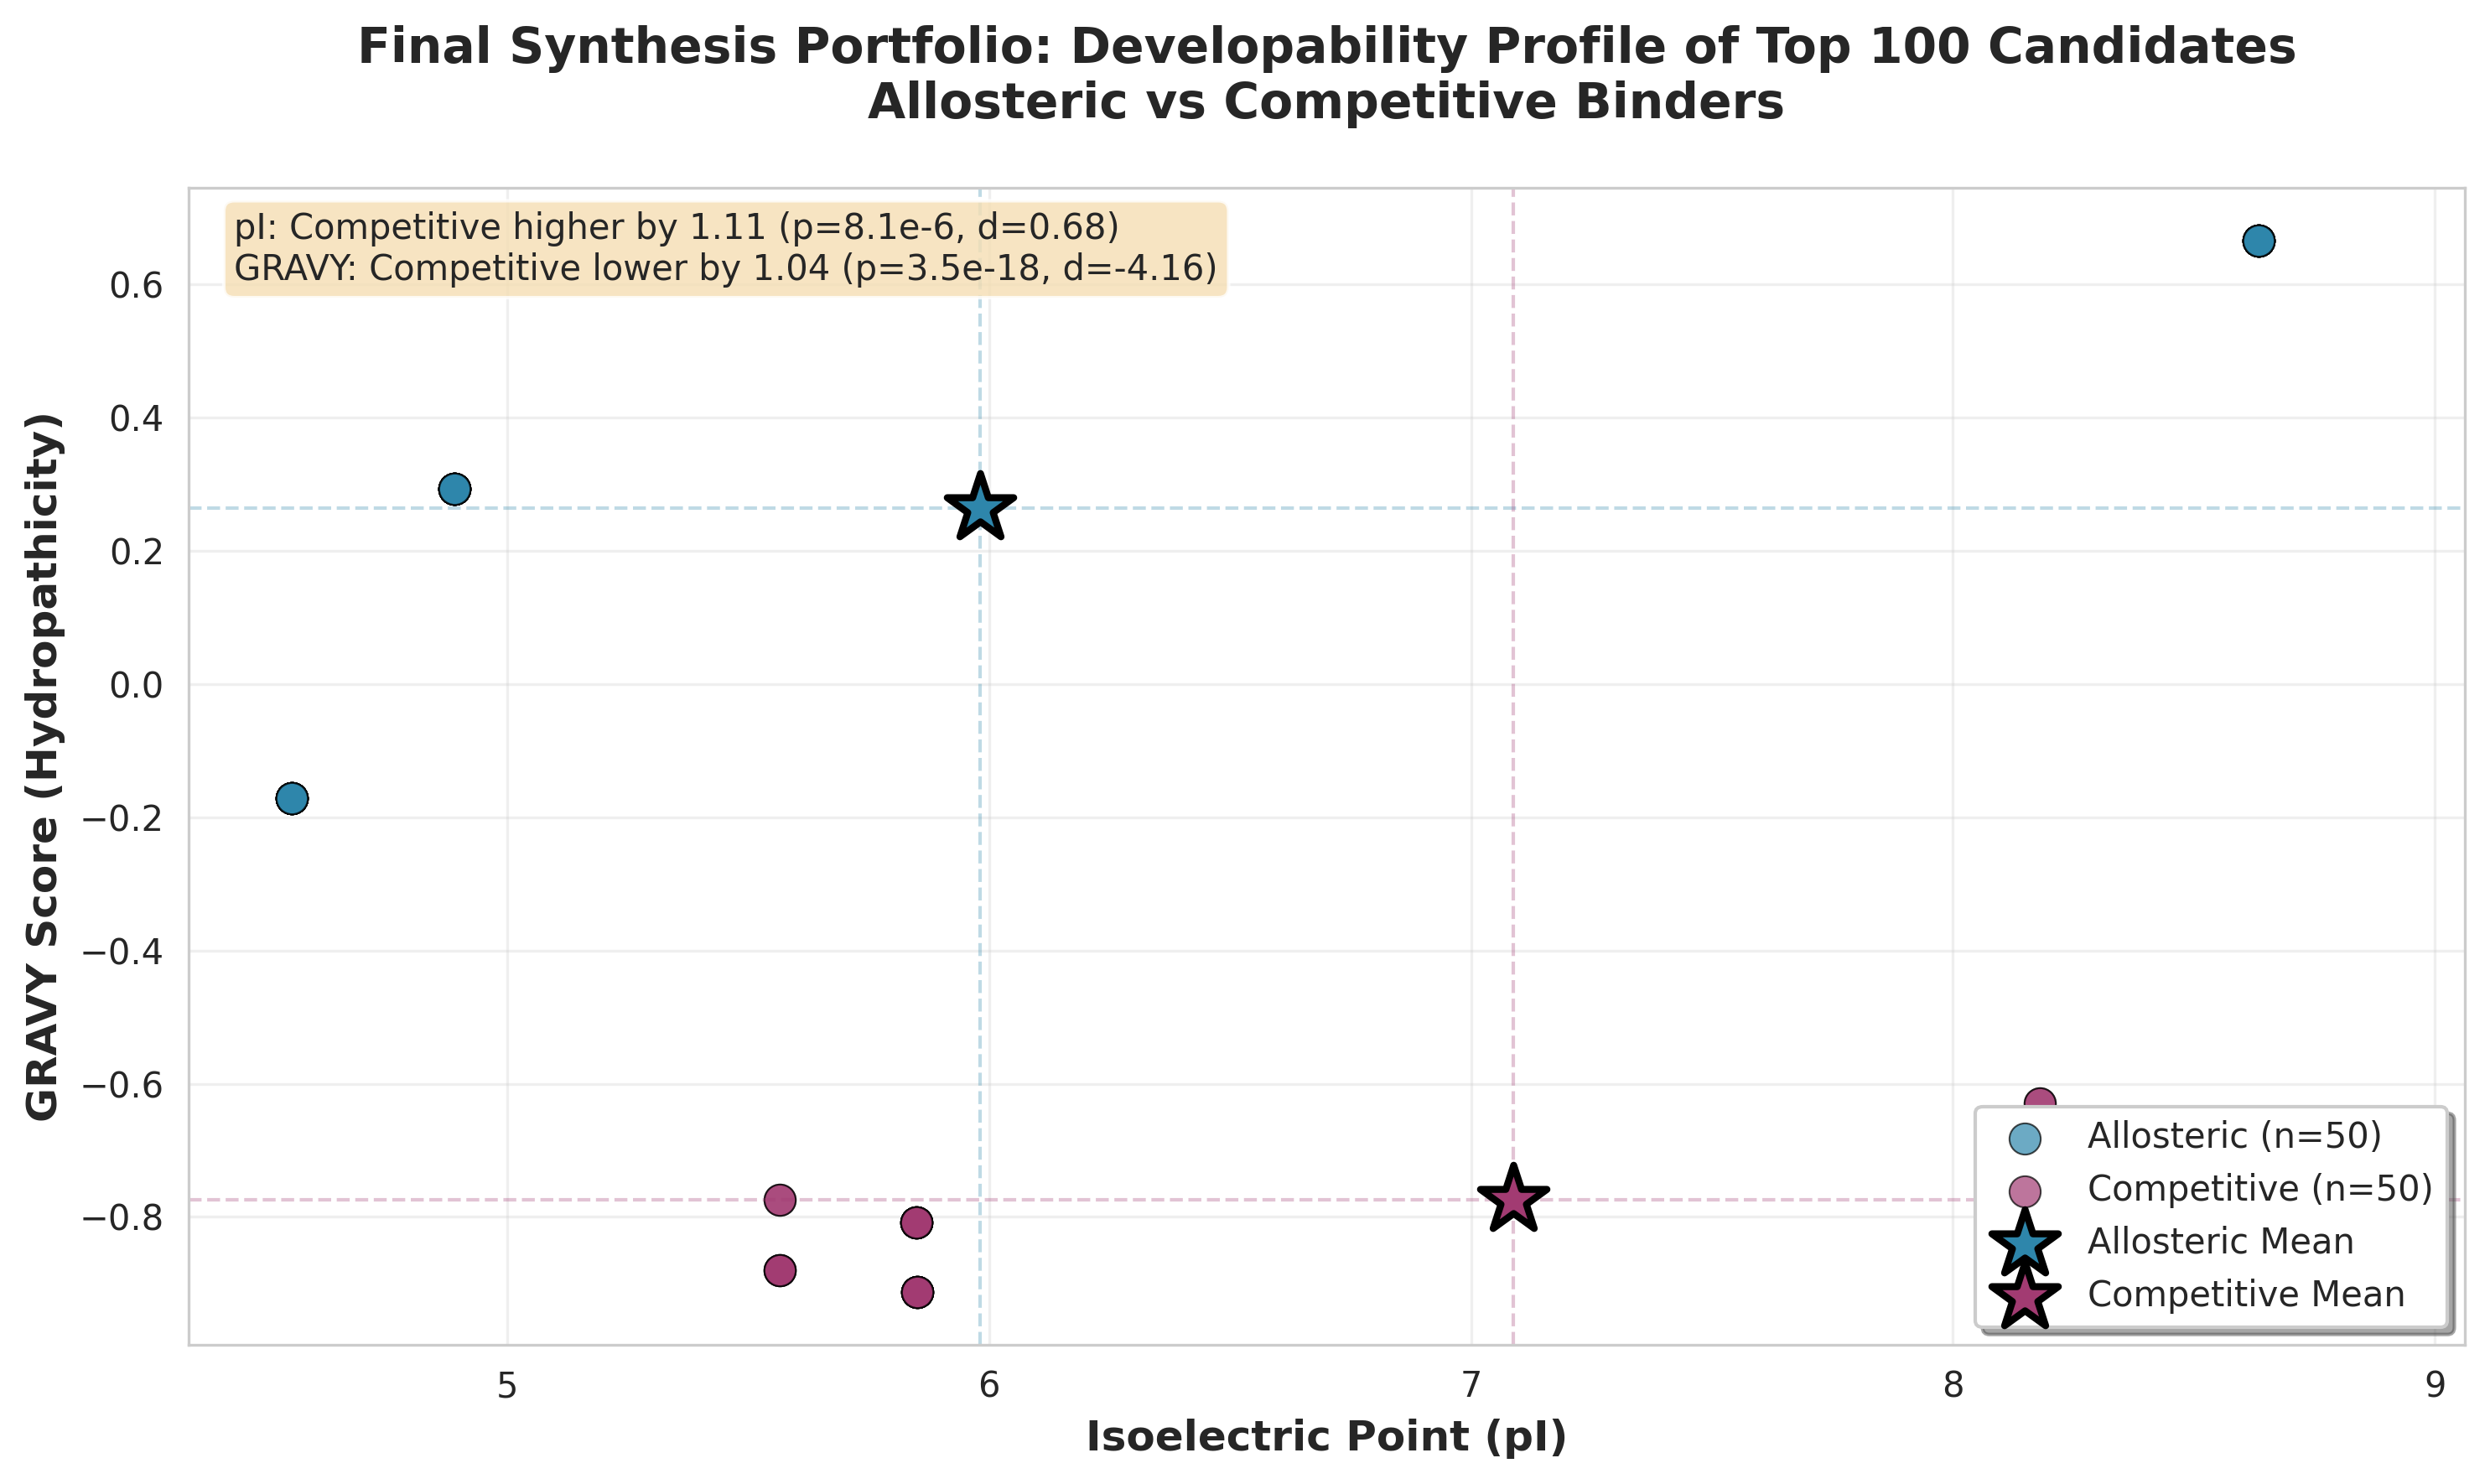


Figure shows clear physicochemical separation between epitope targets:
- Allosteric candidates: More hydrophobic (higher GRAVY), lower pI
- Competitive candidates: More hydrophilic (lower GRAVY), higher pI


In [ ]:

# Create final summary visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create a single figure with key results
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot: GRAVY vs pI, colored by epitope target
allosteric_data = final_portfolio[final_portfolio['Epitope_Target'] == 'Allosteric']
competitive_data = final_portfolio[final_portfolio['Epitope_Target'] == 'Competitive']

ax.scatter(allosteric_data['pI'], allosteric_data['GRAVY_Score'], 
           c='#2E86AB', s=80, alpha=0.7, edgecolors='black', linewidth=0.5,
           label='Allosteric (n=50)')
ax.scatter(competitive_data['pI'], competitive_data['GRAVY_Score'], 
           c='#A23B72', s=80, alpha=0.7, edgecolors='black', linewidth=0.5,
           label='Competitive (n=50)')

# Add mean markers
ax.scatter(allosteric_pi.mean(), allosteric_gravy.mean(), 
           c='#2E86AB', s=400, marker='*', edgecolors='black', linewidth=2,
           label='Allosteric Mean', zorder=10)
ax.scatter(competitive_pi.mean(), competitive_gravy.mean(), 
           c='#A23B72', s=400, marker='*', edgecolors='black', linewidth=2,
           label='Competitive Mean', zorder=10)

# Labels and title
ax.set_xlabel('Isoelectric Point (pI)', fontsize=12, fontweight='bold')
ax.set_ylabel('GRAVY Score (Hydropathicity)', fontsize=12, fontweight='bold')
ax.set_title('Final Synthesis Portfolio: Developability Profile of Top 100 Candidates\n' +
             'Allosteric vs Competitive Binders', 
             fontsize=14, fontweight='bold', pad=20)

# Add reference lines at means
ax.axhline(y=allosteric_gravy.mean(), color='#2E86AB', linestyle='--', 
           alpha=0.3, linewidth=1)
ax.axhline(y=competitive_gravy.mean(), color='#A23B72', linestyle='--', 
           alpha=0.3, linewidth=1)
ax.axvline(x=allosteric_pi.mean(), color='#2E86AB', linestyle='--', 
           alpha=0.3, linewidth=1)
ax.axvline(x=competitive_pi.mean(), color='#A23B72', linestyle='--', 
           alpha=0.3, linewidth=1)

# Add statistical annotations
ax.text(0.02, 0.98, 
        f'pI: Competitive higher by 1.11 (p=8.1e-6, d=0.68)\n' +
        f'GRAVY: Competitive lower by 1.04 (p=3.5e-18, d=-4.16)',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Legend
ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=10)

# Grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('final_synthesis_portfolio_characterization.png', dpi=300, bbox_inches='tight')
print("\n✓ Figure saved: final_synthesis_portfolio_characterization.png")
plt.show()

print("\nFigure shows clear physicochemical separation between epitope targets:")
print("- Allosteric candidates: More hydrophobic (higher GRAVY), lower pI")
print("- Competitive candidates: More hydrophilic (lower GRAVY), higher pI")
